
<h1 align="center">
  Lava, Lava DNF and Loihi x
</h1>


Below is a diagram of the Potjan's model. We wish to use Lava an Intel supported interface to instantiate a cortical model of V1 on Intel Loihi.

<h1 align="center">

<img src="Schematic-diagram-of-the-Potjans-Diesmann-cortical-microcircuit-model.png" 
     width="300" 
     height="350" />
</h1>



# Import some packages.

In [1]:
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.operations.operations import *
from lava.proc.lif.process import LIF
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.magma.core.run_configs import Loihi1SimCfg #Loihi simulator, not  Loihi itself.
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor
from lava.proc.monitor.models import PyMonitorModel
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.kernels.kernels import MultiPeakKernel
import numpy as np
from lava.lib.dnf.utils.plotting import raster_plot


# Cortical Specs:
* 2 columns.
* 4 layers
* 1 excitatory and 1 inhibitory population per layer.
* 85 cells per population 170 cells per layer.

In [2]:

ncolumns=2


### Create the layerwise populations 

In [3]:
ly_2_3_ex = np.ndarray((ncolumns),dtype=object)#,LIF()))
ly_4_ex = np.ndarray((ncolumns),dtype=object)#LIF))
ly_5_ex = np.ndarray((ncolumns),dtype=object)#,LIF))
ly_6_ex = np.ndarray((ncolumns),dtype=object)#,LIF))


ly_2_3_in = np.ndarray((ncolumns),dtype=object)#,LIF))
ly_4_in = np.ndarray((ncolumns),dtype=object)#,LIF))
ly_5_in = np.ndarray((ncolumns),dtype=object)#,LIF))
ly_6_in = np.ndarray((ncolumns),dtype=object)#,LIF))

ncells = 85
for i in range(0,ncolumns):
    ly_2_3_ex[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_4_ex[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_5_ex[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_6_ex[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)


    ly_2_3_in[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_4_in[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_5_in[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)
    ly_6_in[i] = LIF(shape=(ncells,))#, du=2047, dv=2047, vth=200)

    

# Create the connectivity pattern 
* from the Potjan's wiring diagram

### Stereo typed connections:

In [4]:

connections=[]
for i in range(0,ncolumns):
        
    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_ex[i]
            
    one2onec = connect(ly_4_ex[i].s_out, ly_4_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_ex[i]
    one2onec = connect(ly_5_ex[i].s_out, ly_5_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_6_ex[i] 2 ly_6_ex[i]
    one2onec = connect(ly_6_ex[i].s_out, ly_6_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)



In [5]:
    
# one to one connect inhibitory layers to themselves.

for i in range(0,ncolumns):
    #ly_2_3_in[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_2_3_in[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_4_in[i] 2 ly_4_in[i]
    one2onec = connect(ly_4_in[i].s_out, ly_4_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_5_in[i] 2 ly_5_in[i]
    one2onec = connect(ly_5_in[i].s_out, ly_5_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

    #ly_6_in[i] 2 ly_6_in[i]
    one2onec = connect(ly_6_in[i].s_out, ly_6_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

# one to one connect inhibitory layers to exc.


# one to one connect exc layers to inhib.

for i in range(0,ncolumns):

    #ly_2_3_ex[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_in[i]
    one2onec = connect(ly_4_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_in[i]
    one2onec = connect(ly_5_ex[i].s_out, ly_5_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_6_ex[i] 2 ly_6_in[i]
    one2onec = connect(ly_6_ex[i].s_out, ly_6_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

for i in range(0,ncolumns):
    #ly_2_3_in[i] 2 ly_2_3_exc[i]
    ly_2_3_ex
    one2onec = connect(ly_2_3_in[i].s_out, ly_2_3_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)

    #ly_4_in[i] 2 ly_4_exc[i]
    one2onec = connect(ly_4_in[i].s_out, ly_4_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)

    #ly_5_in[i] 2 ly_5_exc[i]
    one2onec = connect(ly_5_in[i].s_out, ly_5_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)
    
    #ly_6_in[i] 2 ly_6_exc[i]
    one2onec = connect(ly_6_in[i].s_out, ly_6_ex[i].a_in, ops=[Weights(-1.0)])
    connections.append(one2onec)


### Less Predictible Connections:

In [6]:
for i in range(0,ncolumns):

    #ly_2_3_ex[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_5_ex[i].s_out, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_in[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_in[i]
    one2onec = connect(ly_2_3_ex[i].s_out, ly_5_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)


In [7]:
for i in range(0,ncolumns):

    one2onec = connect(ly_5_ex[i].s_out, ly_4_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)
    #ly_6_ex[i] 2 ly_6_in[i]
    one2onec = connect(ly_6_ex[i].s_out, ly_4_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    one2onec = connect(ly_6_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)


In [8]:

for i in range(0,ncolumns):

    one2onec = connect(ly_2_3_ex[i].s_out, ly_2_3_in[i].a_in, ops=[Weights(-0.5)])
    connections.append(one2onec)

In [9]:
for i in range(0,ncolumns):

    #ly_2_3_ex[i] 2 ly_2_3_in[i]
    one2onec = connect(ly_4_ex[i].s_out, ly_2_3_ex[i].s_out, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_4_ex[i] 2 ly_4_in[i]
    one2onec = connect(ly_4_ex[i].s_out, ly_5_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)

    #ly_5_ex[i] 2 ly_5_in[i]
    one2onec = connect(ly_5_ex[i].s_out, ly_6_ex[i].a_in, ops=[Weights(1.0)])
    connections.append(one2onec)


In [10]:
one2onec = connect(ly_2_3_ex[0].s_out, ly_2_3_ex[1].s_out, ops=[Weights(5.0)])
connections.append(one2onec)


In [11]:

spike_generator_1 = RateCodeSpikeGen(shape=ncells,)
center_cell=ncells/2.0
spread_across_number_of_cells=ncells # 125
gauss_pattern_1 = GaussPattern(shape=ncells,
                               amplitude=100,
                               mean=center_cell,
                               stddev=spread_across_number_of_cells)
gauss_pattern_1.a_out.connect(spike_generator_1.a_in)

for i in range(0,ncolumns):
    _=connect(spike_generator_1.s_out, ly_4_ex[i].a_in, [Weights(2.5)])


In [12]:

time_steps = 50

monitor_ly_2_3_ex = Monitor()
monitor_ly_2_3_ex.probe(target=ly_2_3_ex[0].s_out, num_steps=time_steps)
monitor_ly_2_3_in = Monitor()
monitor_ly_2_3_in.probe(target=ly_2_3_in[0].s_out, num_steps=time_steps)

monitor_ly_4_ex = Monitor()
monitor_ly_4_ex.probe(target=ly_4_ex[0].s_out, num_steps=time_steps)

#monitor_ly_2_3_ex = Monitor()
#monitor_ly_2_3_ex.probe(target=ly_2_3_ex[0].s_out, num_steps=time_steps)



monitor_input_1 = Monitor()
monitor_input_1.probe(spike_generator_1.s_out, time_steps)


other_column = Monitor()
other_column.probe(ly_2_3_ex[1].s_out, time_steps)



ly_4_ex[0].amplitude = 100
ly_4_ex[0].run(condition=RunSteps(num_steps=time_steps),
        run_cfg=Loihi1SimCfg(select_tag='floating_pt'))





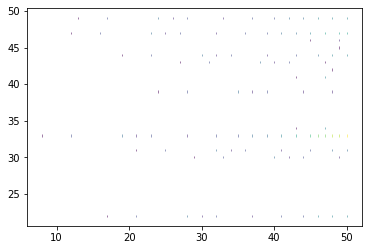

In [13]:
# Get probed data from monitors

data_input1 = monitor_input_1.get_data()\
    [spike_generator_1.name][spike_generator_1.s_out.name]

data_ly_2_3_ex = monitor_ly_2_3_ex.get_data()\
    [ly_2_3_ex[0].name][ly_2_3_ex[0].s_out.name]

data_ly_2_3_in = monitor_ly_2_3_in.get_data()\
    [ly_2_3_in[0].name][ly_2_3_in[0].s_out.name]


data_ly_4_ex = monitor_ly_4_ex.get_data()\
    [ly_4_ex[0].name][ly_4_ex[0].s_out.name]





raster_plot(data_ly_2_3_ex.T)



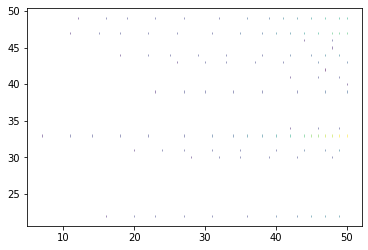

In [14]:

raster_plot(data_ly_4_ex.T)


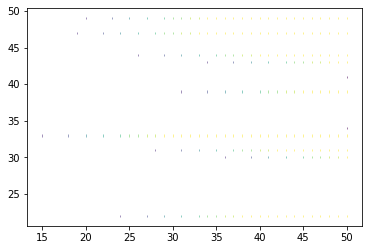

In [15]:
raster_plot(data_ly_2_3_in.T)


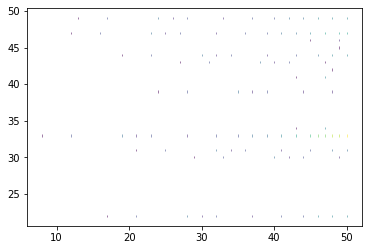

In [16]:
raster_plot(data_ly_2_3_ex.T)

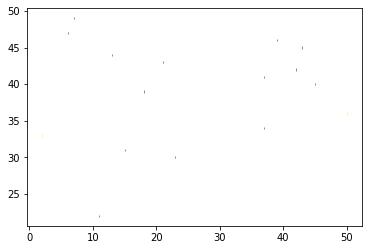

In [17]:

raster_plot(data_input1.T)



### Check to see that brain activity propogated from one side of cortex to the other.

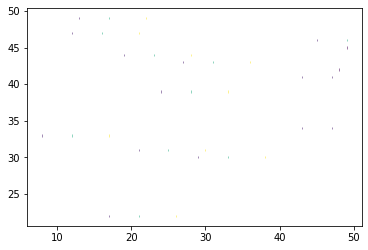

In [18]:
data_ly_2_3_ex = other_column.get_data()\
    [ly_2_3_ex[1].name][ly_2_3_ex[1].s_out.name]


raster_plot(data_ly_2_3_ex.T)
